In [1]:
import pandas as pd
import numpy as np

In [2]:
# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt


RFM-анализ

Способ сегментации по 3-м показателям:

    Recency (давность)  1-4
    Frequency (частота)  1-4
    Monetary (деньги) 1-4
(1 лучше, чем 4)

In [3]:
path = "C:/Users/maksa/product analytics/RFM_ht_data.csv"
df = pd.read_csv(path, sep=',' , low_memory=False)
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [6]:
df.CustomerCode.nunique()

123733

Какое максимальное кол-во покупок было совершено одним пользователем?

In [7]:
df.groupby('CustomerCode').agg({'Amount':'count'}).sort_values('Amount', ascending=False).head()

,Amount
CustomerCode,
19057820,204
13215452,113
13032521,106
19080880,99
99003061,90


Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? 

Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М: от 0 до 25%

ответ: 765


In [8]:
df.groupby('CustomerCode').agg({'Amount':'sum'}).describe()

,Amount
count,123733.000000
mean,3331.870758
std,6131.418681
min,-80.000000
25%,765.000000
50%,1834.480000
75%,4008.840000
max,711487.710000


Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?



In [9]:
df.groupby('CustomerCode').agg({'InvoiceNo':'size'}).describe()

,InvoiceNo
count,123733.000000
mean,2.689097
std,2.894494
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,204.000000



ответ : 4 (следующ.после 3)

In [10]:
#  тот же вопрос
df.groupby('CustomerCode').agg({'InvoiceNo':'size'}).quantile(0.75)

InvoiceNo    3.0
Name: 0.75, dtype: float64

<AxesSubplot:xlabel='CustomerCode'>

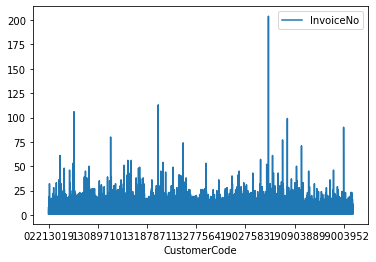

In [11]:
# для наглядности  по y - количество покупок
df.groupby('CustomerCode').agg({'InvoiceNo':'count'}).plot()

Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

ответ: 8 (в датах классы в обратную сторону, чем меньше тем лучше)

In [12]:
last_date = df.InvoiceDate.max()

In [13]:
(last_date - df.groupby('CustomerCode').agg({'InvoiceDate':'max'})).describe()

,InvoiceDate
count,123733
mean,9 days 19:08:44.901198548
std,8 days 13:27:33.303577093
min,0 days 00:00:00
25%,2 days 00:00:00
50%,8 days 00:00:00
75%,16 days 00:00:00
max,29 days 00:00:00


### Общая таблица для RFM-анализа

    Recency (давность)
    Frequency (частота)
    Monetary (деньги) 

In [14]:
rfmTable = df.groupby('CustomerCode')\
             .agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),  # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()})   # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [15]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


In [16]:
rfmTable.describe()

,recency,frequency,monetary_value
count,123733.000000,123733.000000,123733.000000
mean,9.797742,2.689097,3331.870758
std,8.560802,2.894494,6131.418681
min,0.000000,1.000000,-80.000000
25%,2.000000,1.000000,765.000000
50%,8.000000,2.000000,1834.480000
75%,16.000000,3.000000,4008.840000
max,29.000000,204.000000,711487.710000


In [17]:
quantiles = rfmTable.describe()

In [18]:
quantiles['recency']['75%']

16.0

In [19]:
#     дополнительная таблица
rfmSegmentation = rfmTable

In [20]:
#     функции для распределения по классам/сегментам

def RClass(value,parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name]['25%']:
        return 1
    elif value <= quantiles_table[parameter_name]['50%']:
        return 2
    elif value <= quantiles_table[parameter_name]['75%']: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name]['25%']:
        return 4
    elif value <= quantiles_table[parameter_name]['50%']:
        return 3
    elif value <= quantiles_table[parameter_name]['75%']: 
        return 2
    else:
        return 1

In [21]:
#  сегментируем
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency', quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)  \
                            + rfmSegmentation.F_Quartile.map(str)  \
                            + rfmSegmentation.M_Quartile.map(str)

In [22]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


In [23]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
214       60
114       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64

#### Варианты интерпретации

In [24]:
#  RF-анализ + количество клиентов на пересечении
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


In [25]:
#  RF-анализ + медианная сумма покупок на пересечении
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)

In [26]:
rfm_table

F_Quartile,1,2,3,4
R_Quartile,,,,
1,5768,2733,1805,729
2,4947,2895,1868,814
3,4179,2770,1813,773
4,3822,2682,1813,859


In [27]:
# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

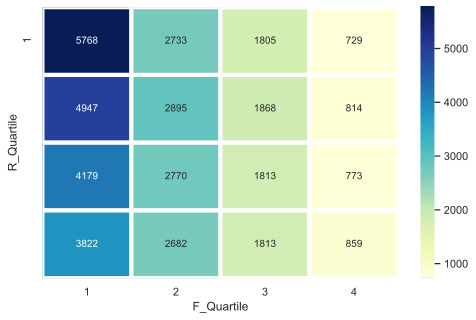

In [28]:
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)
plt.savefig("heatmapRFM.png") # save as png

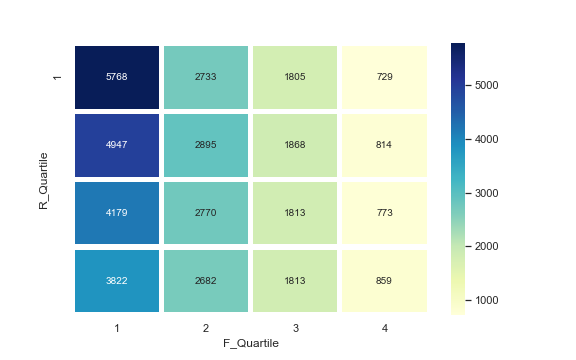

In [29]:
from IPython.display import Image
Image(filename='heatmapRFM.png')